# *Heart Disease Cleveland UCI*: Анализ данных

https://www.kaggle.com/code/yuvrajgavhane/heart-disease-eda-and-modelling

### Описание данных

**Content**

*There are 13 attributes*

* **age**: age in years
* **sex**: sex (1 = male; 0 = female)
* **cp**: chest pain type
-- Value 0: typical angina
-- Value 1: atypical angina
-- Value 2: non-anginal pain
-- Value 3: asymptomatic
* **trestbps**: resting blood pressure (in mm Hg on admission to the hospital)
* **chol**: serum cholestoral in mg/dl
* **fbs**: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
* **restecg**: resting electrocardiographic results
-- Value 0: normal
-- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
-- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
* **thalach**: maximum heart rate achieved
* **exang**: exercise induced angina (1 = yes; 0 = no)
* **oldpeak** = ST depression induced by exercise relative to rest
* **slope**: the slope of the peak exercise ST segment
-- Value 0: upsloping
-- Value 1: flat
-- Value 2: downsloping
* **ca**: number of major vessels (0-3) colored by flourosopy
* **thal**: 0 = normal; 1 = fixed defect; 2 = reversable defect
and the label
* **condition**: 0 = no disease, 1 = disease

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### 1. Считывание данных

Здесь также проведем первичный визуальный анализ

In [2]:
df = pd.read_csv("heart_cleveland_upload.csv")

Посмотрим на данные и их характеристики визуально

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,297.0,54.542088,9.049736,29.0,48.0,56.0,61.0,77.0
sex,297.0,0.676768,0.468500,0.0,0.0,1.0,1.0,1.0
cp,297.0,2.158249,0.964859,0.0,2.0,2.0,3.0,3.0
trestbps,297.0,131.693603,17.762806,94.0,120.0,130.0,140.0,200.0
chol,297.0,247.350168,51.997583,126.0,211.0,243.0,276.0,564.0
fbs,297.0,0.144781,0.352474,0.0,0.0,0.0,0.0,1.0
restecg,297.0,0.996633,0.994914,0.0,0.0,1.0,2.0,2.0
thalach,297.0,149.599327,22.941562,71.0,133.0,153.0,166.0,202.0
exang,297.0,0.326599,0.469761,0.0,0.0,0.0,1.0,1.0
oldpeak,297.0,1.055556,1.166123,0.0,0.0,0.8,1.6,6.2


In [6]:
# колонки с непрерывными данными
col_continuous = [
    'age', 
    'trestbps', 
    'chol', 
    'thalach', 
    'oldpeak',
]

# колонки с категориальными данными
col_categorial = [
    col 
    for col in df.columns 
    if col not in col_continuous
]

### 2. Фильтрация выбросов

* Построим **boxplot** для всех непрерывных признаков и удалим выбросы.
* Последних в исходных данных не так много - мы не сильно уменьшим исходный датафрейм, но при этом предотвратим в дальнейшем влияние нетипичных значений на статистики или поведение моделей

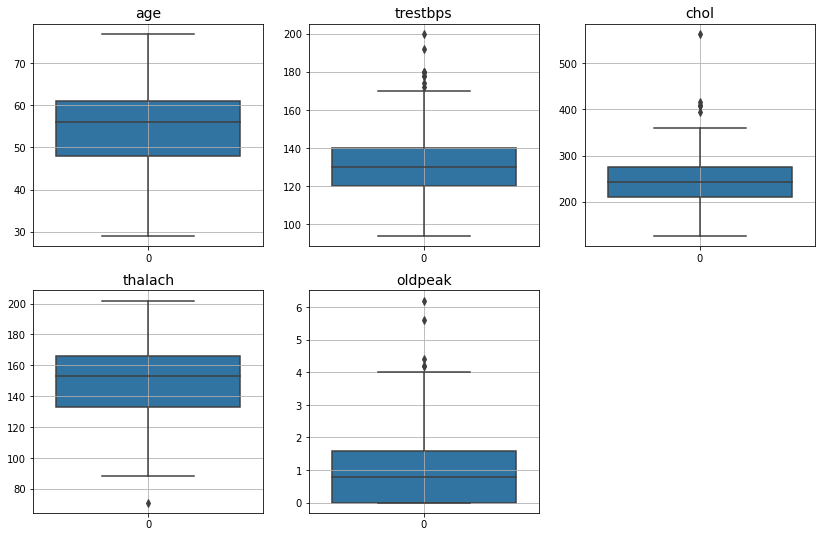

In [7]:
plt.figure(figsize=(14, 9))

for i, col in enumerate(col_continuous):
    plt.subplot(int(f"23{i+1}"))
    sns.boxplot(data=df[col])
    plt.title(col, fontsize=14)
    plt.grid()

Удалим выбросы там, где они есть

In [8]:
def get_whiskers(data, col_name):
    """Расчет левого и правого усов для данных из df в колонке col_name."""
    
    iqr = data.describe().loc["75%", col_name] - data.describe().loc["25%", col_name]
    
    whisker_left = data.describe().loc["25%", col_name] - 1.5 * iqr
    whisker_right = data.describe().loc["75%", col_name] + 1.5 * iqr
    
    return whisker_left, whisker_right

In [9]:
df_filtered = df[
    (df["trestbps"] <= get_whiskers(df, "trestbps")[1])
    & (df["chol"] <= get_whiskers(df, "chol")[1])
    & (df["thalach"] >= get_whiskers(df, "thalach")[0])
    & (df["oldpeak"] <= get_whiskers(df, "oldpeak")[1])
]

df_filtered.shape

(278, 14)

Порядка 6% данных "отсеяли".

Проверим, что все ок стало

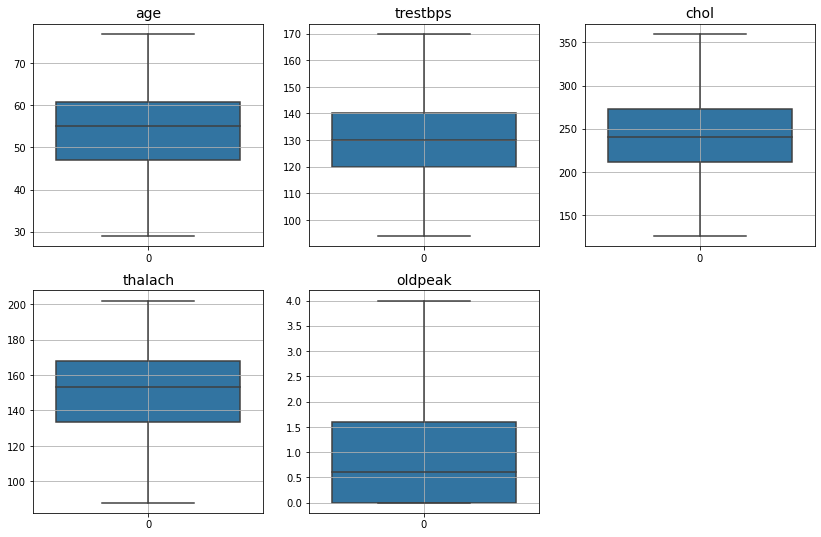

In [10]:
plt.figure(figsize=(14, 9))

for i, col in enumerate(col_continuous):
    plt.subplot(int(f"23{i+1}"))
    sns.boxplot(data=df_filtered[col])
    plt.title(col, fontsize=14)
    plt.grid()

**Посмотрим на то, сколько объектов из класса с condition = 1 и сколько из класса condition = 0**

In [11]:
cond_1 = df_filtered.loc[df_filtered["condition"] == 1, "condition"].size
cond_0 = df_filtered.loc[df_filtered["condition"] == 0, "condition"].size

print(f"Количество объектов condition = 1: {cond_1}\nКоличество объектов condition = 0: {cond_0}")

Количество объектов condition = 1: 124
Количество объектов condition = 0: 154


### 3. Корреляция данных

* Посмотрим на корреляцию всех данных в датасете.
* При этом не очень корректно смотреть на корреляцию категориальных признаков. Но при этом сам коэффициент корреляции (между непрерывной и категориальной величинами) даст понимание, насколько сильно одна влияет на другую. Это может пригодиться, если будем использовать, например, логистическую регрессию.

In [12]:
df_filtered.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
age,1.000000,-0.061914,0.098931,0.292460,0.166457,0.119911,0.143977,-0.410591,0.097351,0.199920,0.144333,0.387391,0.116218,0.228983
sex,-0.061914,1.000000,0.050959,-0.004654,-0.127941,0.059518,0.060945,-0.058159,0.183072,0.166299,0.060060,0.131930,0.404837,0.312778
cp,0.098931,0.050959,1.000000,-0.064046,0.054892,-0.065580,0.084110,-0.330965,0.370101,0.192125,0.135373,0.220829,0.287475,0.400245
trestbps,0.292460,-0.004654,-0.064046,1.000000,0.126390,0.127722,0.158564,-0.072819,-0.001276,0.141301,0.080870,0.097997,0.084329,0.125136
chol,0.166457,-0.127941,0.054892,0.126390,1.000000,0.013877,0.123700,-0.013934,0.070748,-0.023374,-0.049958,0.112469,-0.004560,0.105708
fbs,0.119911,0.059518,-0.065580,0.127722,0.013877,1.000000,0.068809,-0.024462,-0.023161,0.019142,0.057008,0.164456,0.027797,0.001061
restecg,0.143977,0.060945,0.084110,0.158564,0.123700,0.068809,1.000000,-0.104397,0.110740,0.100569,0.128112,0.121705,-0.006819,0.180018
thalach,-0.410591,-0.058159,-0.330965,-0.072819,-0.013934,-0.024462,-0.104397,1.000000,-0.395419,-0.347443,-0.381355,-0.301245,-0.292858,-0.426779
exang,0.097351,0.183072,0.370101,-0.001276,0.070748,-0.023161,0.110740,-0.395419,1.000000,0.321733,0.253545,0.159330,0.337627,0.416150
oldpeak,0.199920,0.166299,0.192125,0.141301,-0.023374,0.019142,0.100569,-0.347443,0.321733,1.000000,0.527910,0.239461,0.310033,0.428431


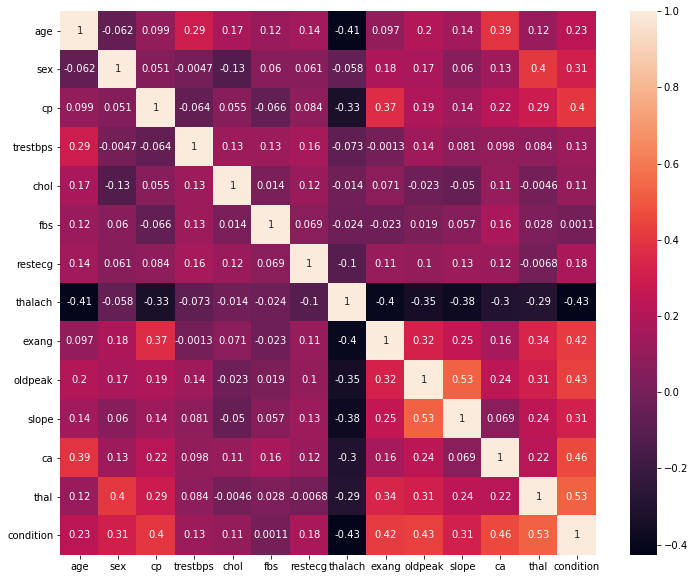

In [13]:
plt.figure(figsize=(12,10))
sns.heatmap(df_filtered.corr(), annot=True);

Рассмотрим порог корреляции 0.35. Больше этого этого порога наблюдается взаимосвязь у следующих пар признаков:

* age / ca

* sex / thal

* cp / exang

* oldpeak / slope

А также у следующих пар, включающих целевую переменную **condition**

* cp / condition

* oldpeak / condition

* exang / condition

* ca / condition

* thal / condition

## 4. Визуализация зависимостей пар признаков с корреляцией больше порога 0.35

In [14]:
def data_plot(data, col_name_x, col_name_y, plot_type="bar"):
    
    if plot_type == "both":
        
        plt.figure(figsize=(15, 4))
        
        plt.subplot(121)
        sns.barplot(x=data[col_name_x], y=data[col_name_y], data=data)
        plt.xlabel(col_name_x, fontsize=14)
        plt.ylabel(col_name_y, fontsize=14)
        plt.title(f"Зависимость {col_name_y} и {col_name_x}", fontsize=14)
        plt.grid();
        
        plt.subplot(122)
        sns.countplot(x=data[col_name_x], hue=data[col_name_y])
        plt.xlabel(col_name_x, fontsize=14)
        plt.ylabel(col_name_y, fontsize=14)
        plt.title(f"Зависимость {col_name_y} и {col_name_x}", fontsize=14)
        plt.grid();
        
        return
        
    plt.figure(figsize=(7, 4))
    plt.xlabel(col_name_x, fontsize=14)
    plt.ylabel(col_name_y, fontsize=14)
    plt.title(f"Зависимость {col_name_y} и {col_name_x}", fontsize=14)
    plt.grid();
    
    if plot_type == "bar":
        sns.barplot(x=data[col_name_x], y=data[col_name_y], data=data)
    elif plot_type == "count":
        sns.countplot(x=data[col_name_x], hue=data[col_name_y])
    else:
        raise NotImplementedError

### 4.1. Зависимость age и ca / ca и condition

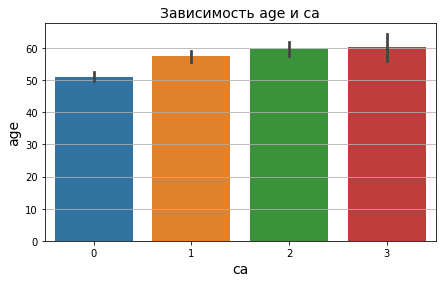

In [15]:
data_plot(df_filtered, col_name_x="ca", col_name_y="age")

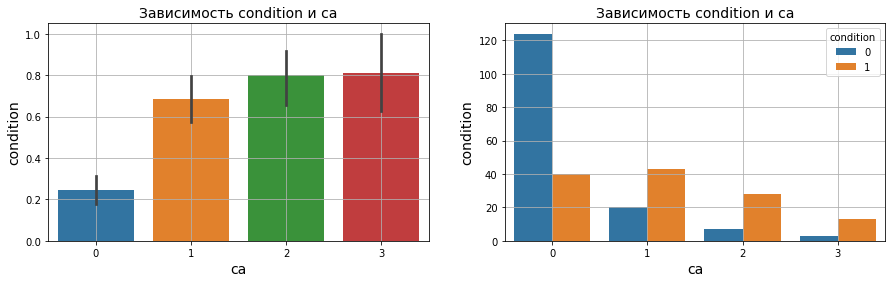

In [16]:
data_plot(df_filtered, col_name_x="ca", col_name_y="condition", plot_type="both")

> * Из графика выше видно, что количество **ca** (количество крупных сосудов по версии гугл переводчика) увеличивается с возрастом.
> * При этом признак **ca** имеет "высокую положительную корреляцию" с целевой переменной: вероятность болезни увеичивается при увеличении **ca**. 
> * Признак **ca >= 1**: пациентов с болезнью больше, чем здоровых. При **ca = 0** обратная статистка: количество здоровых больше.

### 4.2. Зависимость sex и thal / thal и condition

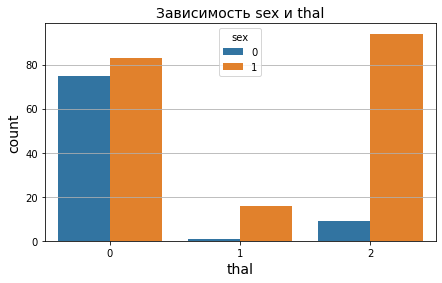

In [17]:
data_plot(df_filtered, col_name_x="thal", col_name_y="sex", plot_type="count")

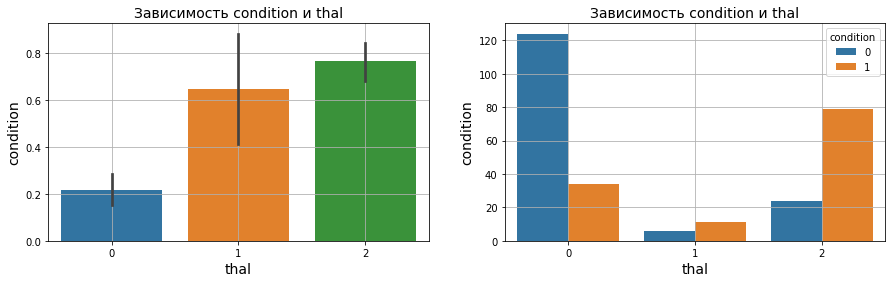

In [18]:
data_plot(df_filtered, col_name_x="thal", col_name_y="condition", plot_type="both")

> * У мужчин и женщин вероятность встретить thal = 0 (нормальное значение) примерно одинаковая
> * Вероятность встретить thal = 1 или 2 у мужчин выше
> * Признак **thal** имеет "высокую положительную корреляцию" с целевой переменной: при **thal=1** или **thal=2** вероятность болезни увеличивается.
> * Признак **thal >= 1**: пациентов с болезнью больше, чем здоровых. При **thal = 0** обратная статистка: количество здоровых больше.

### 4.3. Зависимость cp и exang / cp и condition / exang и condition
cp - тип боли в груди

exang - стенокардия, вызванная физ.нагрузкой

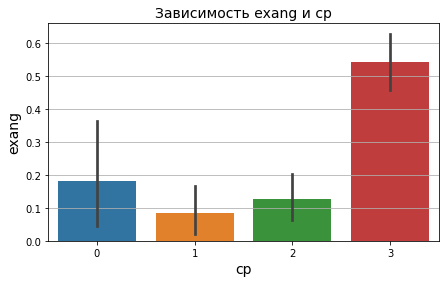

In [19]:
data_plot(df_filtered, col_name_x="cp", col_name_y="exang")

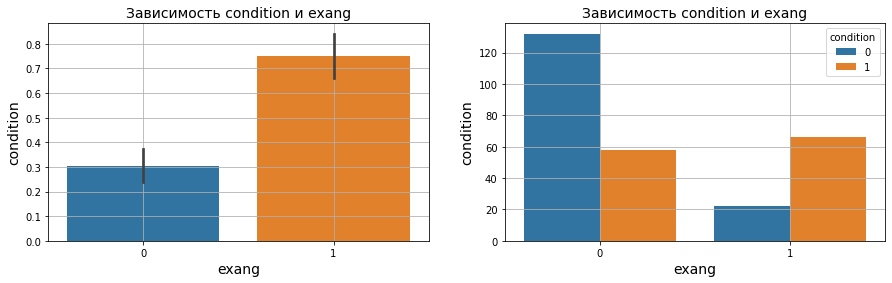

In [20]:
data_plot(df_filtered, col_name_x="exang", col_name_y="condition", plot_type="both")

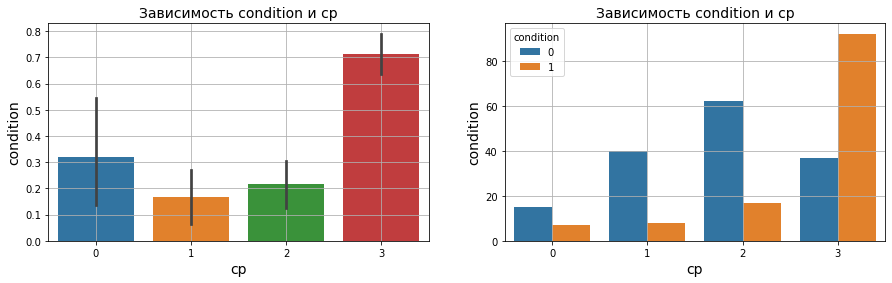

In [21]:
data_plot(df_filtered, col_name_x="cp", col_name_y="condition", plot_type="both")

> * У пациентов, у которых стенокардия была вызвана физ. нагрузкой (**exang**), чаще всего не было боли в груди (**cp=3** - бессимптоная боль, интерпретировал, как нет боли)
> * При **exang = 1** - вероятность болезни сердца выше
> * Вероятность болезни сердца выше при бессимптомных болях в груди (**cp=3** их отсутствие?) выше. При **cp = 0, 1, 2** пациентов с болезнью меньше, чем без болезни.

### 4.4. Зависимость oldpeak и slope / oldpeak и condition

<Figure size 576x1440 with 0 Axes>

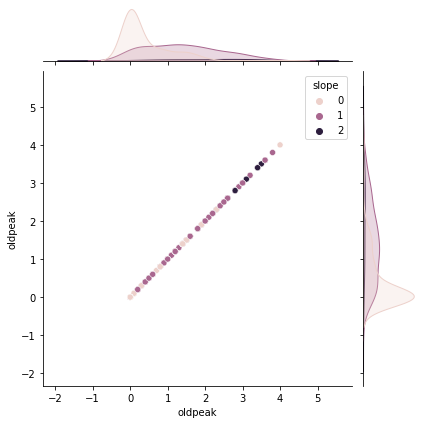

In [22]:
plt.figure(figsize=(8,20))
sns.jointplot(data=df_filtered, x='oldpeak', y='oldpeak', hue='slope')
plt.show()

<Figure size 576x1440 with 0 Axes>

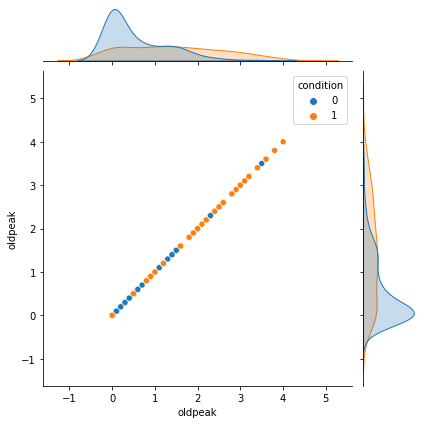

In [23]:
plt.figure(figsize=(8,20))
sns.jointplot(data=df_filtered, x='oldpeak', y='oldpeak', hue='condition')
plt.show()

> * **Slope=2** наблюдается у людей с **oldpeak > 2.5**
> * У людей с **oldpeak > 2** болезнь более вероятна

## 5. Распределение непрерывных признаков

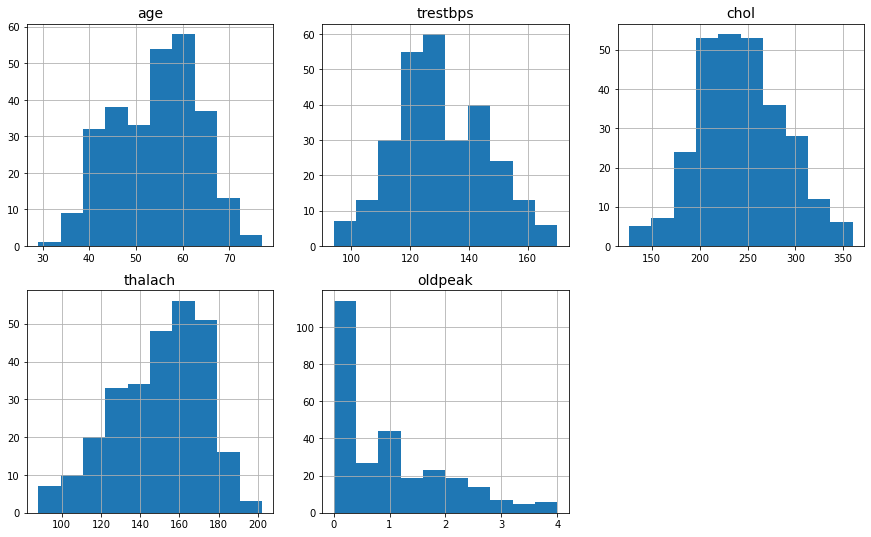

In [24]:
plt.figure(figsize=(15, 9))

for i, col in enumerate(col_continuous):
    plt.subplot(int(f"23{i+1}"))
    plt.hist(df_filtered[col])
    plt.title(col, fontsize=14)
    plt.grid()